MÔ HÌNH LEAKY INTEGRATE-AND-FIRE (LIF)

Tham số mô hình:
  - Điện dung màng (C_m): 1.0 µF/cm²
  - Độ dẫn rò (g_L): 0.1 mS/cm²
  - Điện thế nghỉ (E_L): -70.0 mV
  - Ngưỡng phát xung (V_th): -50.0 mV
  - Điện thế reset (V_reset): -70.0 mV
  - Hằng số thời gian màng (τ_m): 10.0 ms
  - Bước thời gian mô phỏng (dt): 0.1 ms

ĐANG CHẠY MÔ PHỎNG...

Kết quả mô phỏng với dòng sóng vuông:
  - Số lượng spike: 0
  - Tần số trung bình: 0.00 Hz


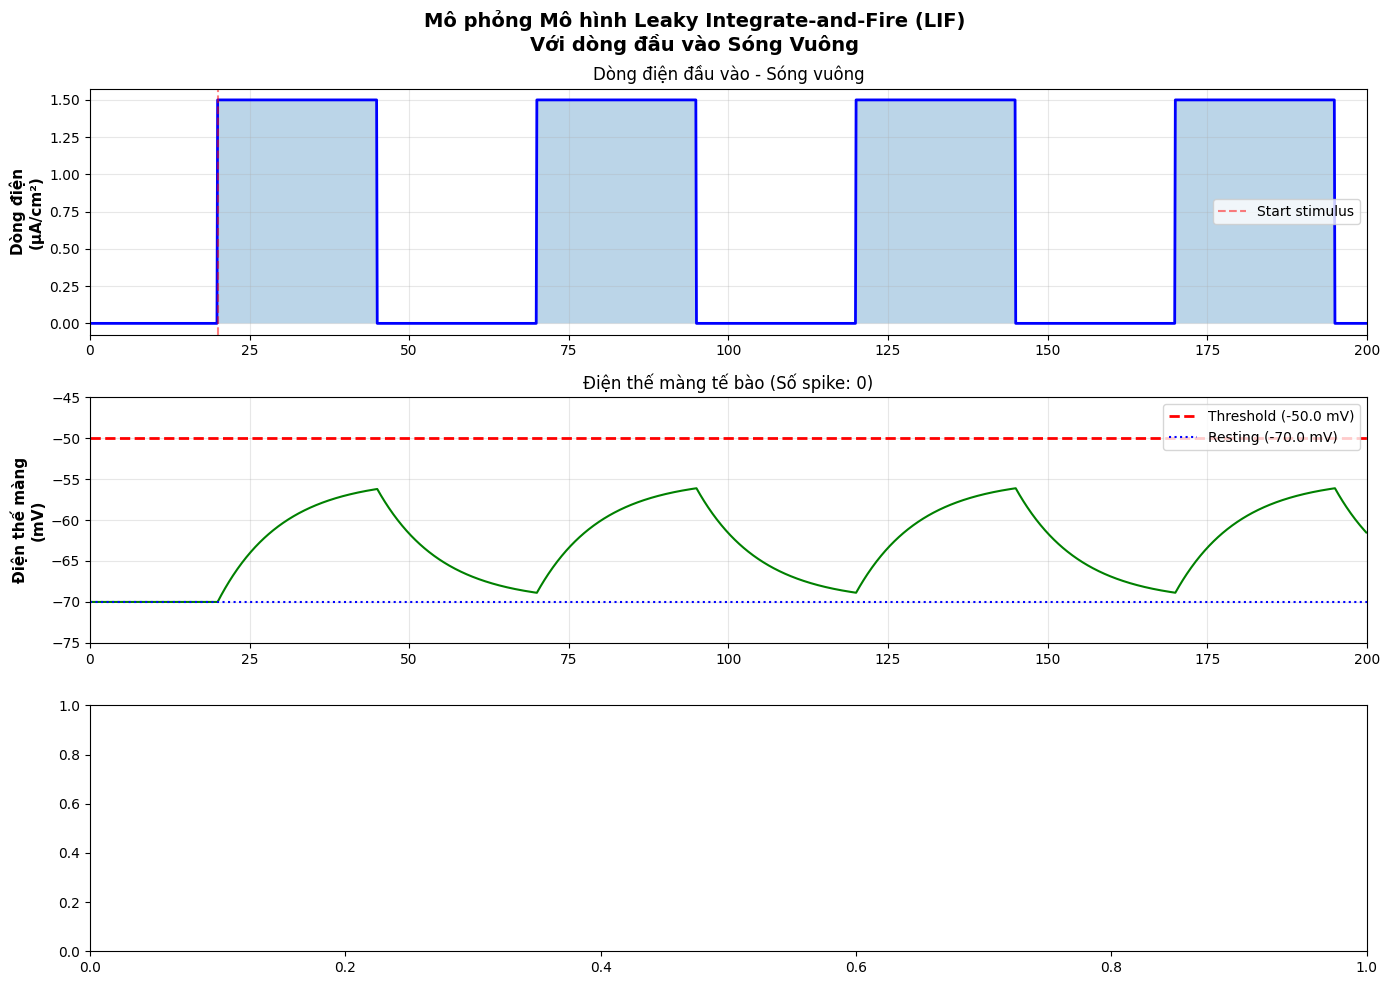


PHÂN TÍCH ẢNH HƯỞNG CỦA BIÊN ĐỘ DÒNG ĐIỆN


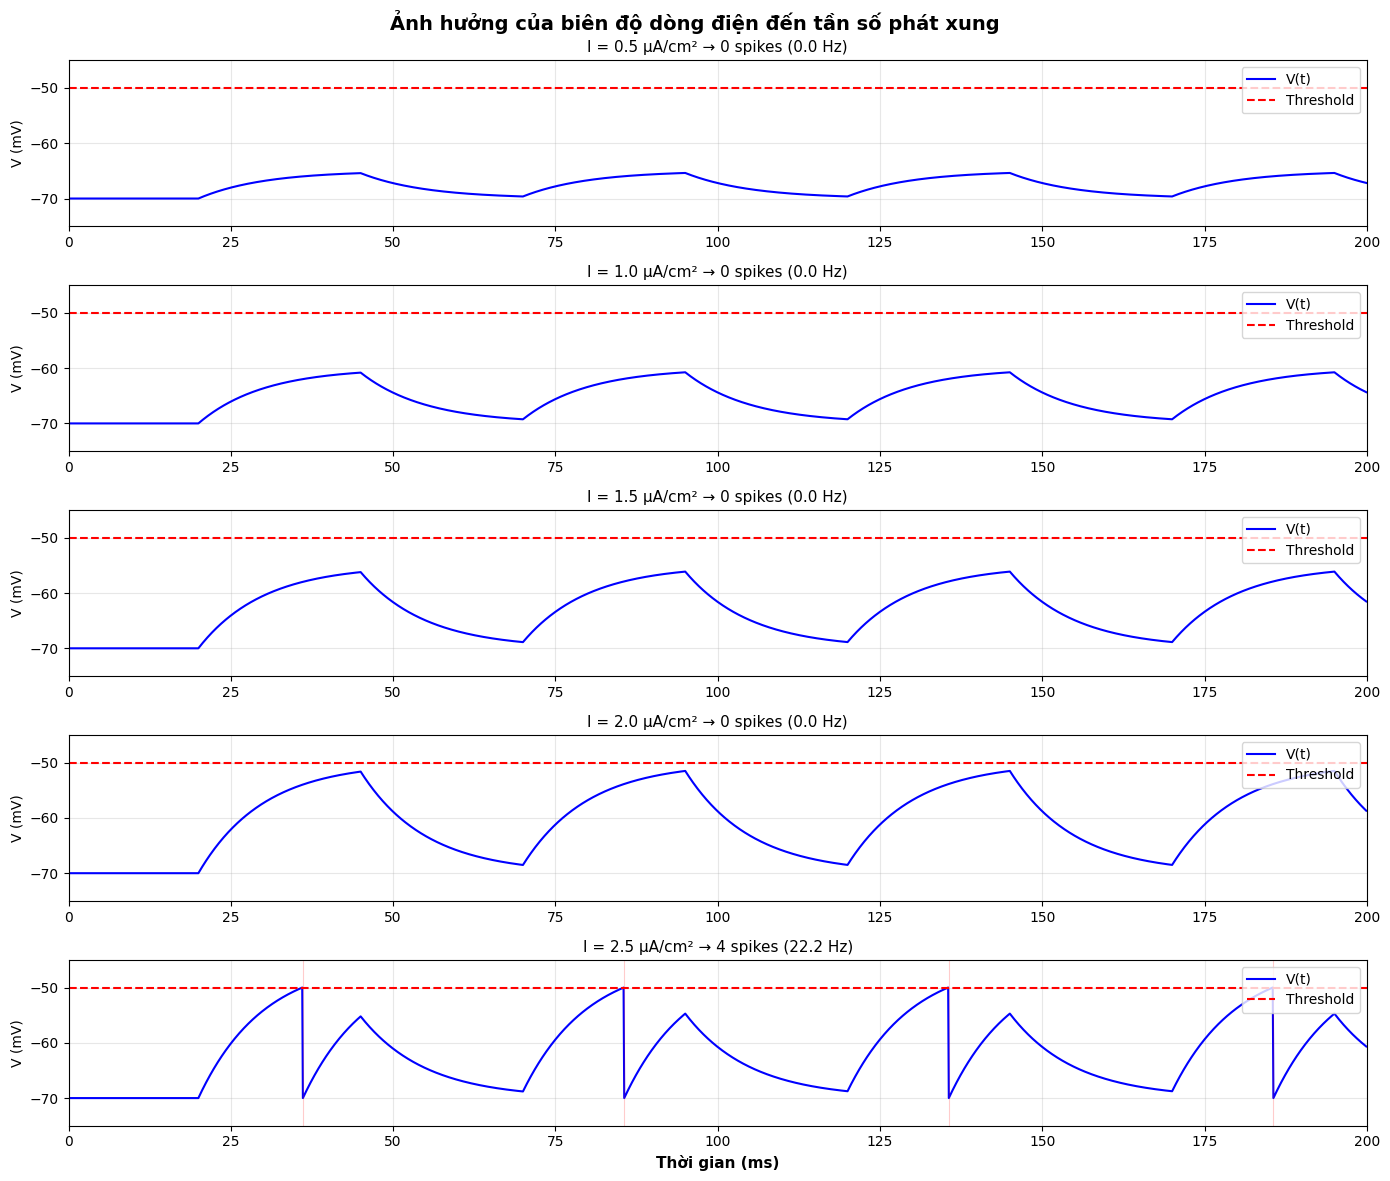


ĐƯỜNG CONG F-I (TẦN SỐ - DÒNG ĐIỆN)


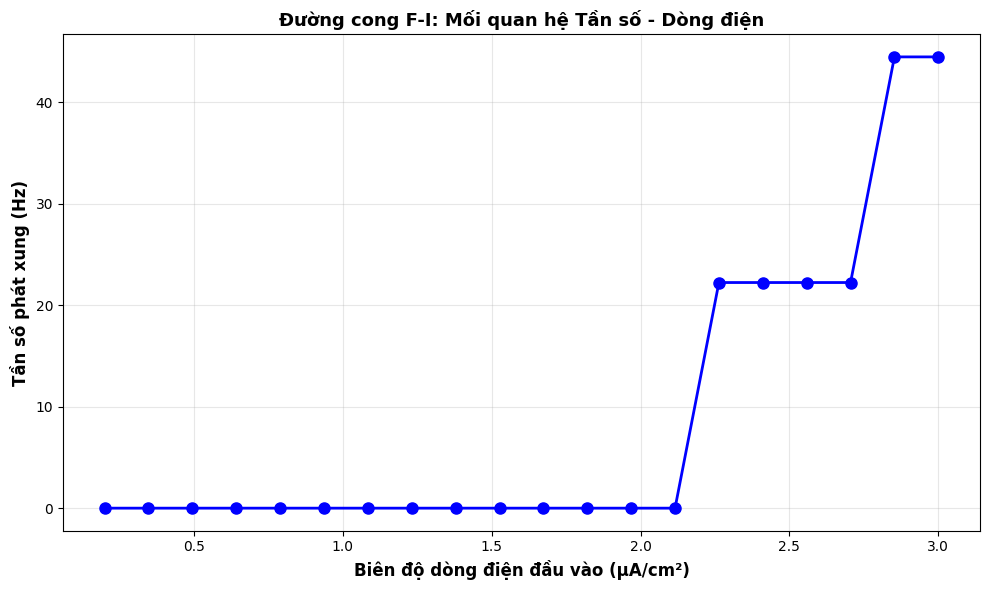


Kết quả phân tích F-I curve:
  - Dòng điện tối thiểu để phát xung: ~2.26 µA/cm²
  - Tần số tối đa đạt được: 44.44 Hz

SO SÁNH: DÒNG SÓNG VUÔNG vs DÒNG HẰNG


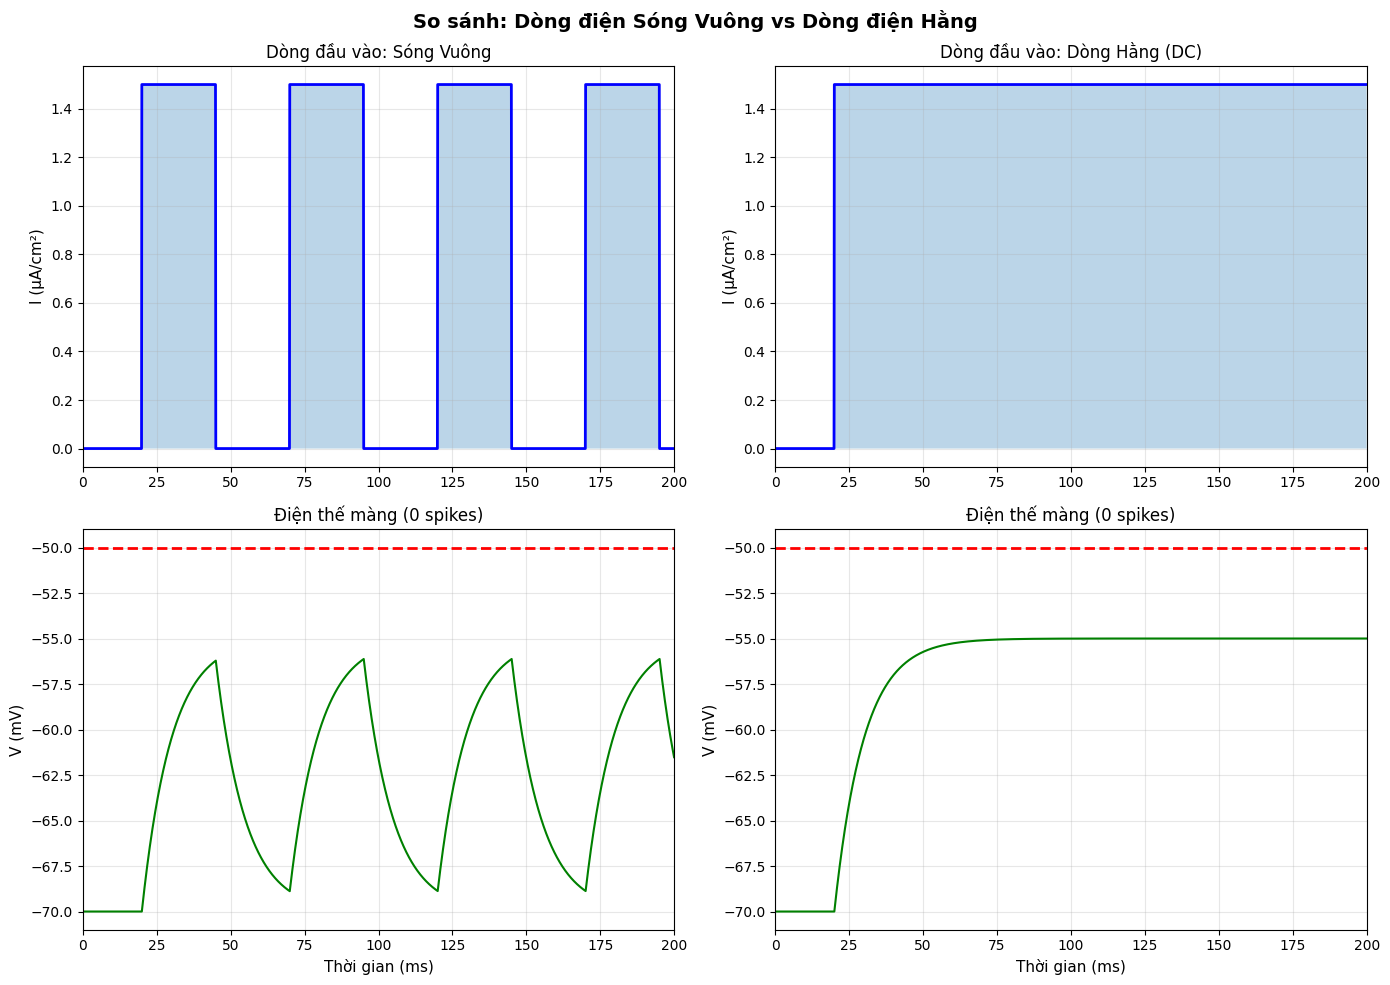


So sánh kết quả:
  Dòng sóng vuông: 0 spikes, tần số = 0.00 Hz
  Dòng hằng:       0 spikes, tần số = 0.00 Hz

GIẢI THÍCH CƠ CHẾ HOẠT ĐỘNG CỦA MÔ HÌNH LIF

1. PHƯƠNG TRÌNH CƠ BẢN:
   τ_m * dV/dt = -(V - E_L) + R_m * I_ext
   
   Trong đó:
   - τ_m = C_m / g_L: hằng số thời gian màng
   - R_m = 1 / g_L: điện trở màng
   - E_L: điện thế nghỉ
   
2. CƠ CHẾ TÍCH HỢP (INTEGRATE):
   - Dòng điện đầu vào I_ext làm tăng điện thế màng V
   - V tích lũy dần theo thời gian (integrate)
   - Khi V đạt ngưỡng V_th → phát xung (spike)
   
3. CƠ CHẾ RÒ RỈ (LEAKY):
   - Thành phần -(V - E_L) tạo dòng rò về điện thế nghỉ
   - Nếu không có dòng đầu vào, V sẽ giảm dần về E_L
   - τ_m quyết định tốc độ rò rỉ
   
4. CƠ CHẾ RESET:
   - Sau khi phát xung, V được reset về V_reset
   - Neuron có thời gian "refractory" ngắn (implicitly)
   - Sau đó chu kỳ lặp lại
   
5. ỨNG DỤNG:
   - Mô hình đơn giản nhưng hiệu quả
   - Tính toán nhanh, phù hợp mạng lớn
   - Nắm bắt được tính chất cơ bản của neuron sinh học


K

In [1]:
# File: lif_model_simulation.ipynb
# Mô phỏng mô hình Leaky Integrate-and-Fire (LIF)

import numpy as np
import matplotlib.pyplot as plt

# ============================================================================
# PHẦN 1: ĐỊNH NGHĨA CÁC THAM SỐ CỦA MÔ HÌNH LIF
# ============================================================================

# Tham số màng tế bào
C_m = 1.0          # Điện dung màng (µF/cm²)
g_L = 0.1          # Độ dẫn rò (mS/cm²)
E_L = -70.0        # Điện thế nghỉ (mV)
V_th = -50.0       # Ngưỡng phát xung (mV)
V_reset = -70.0    # Điện thế reset sau spike (mV)

# Hằng số thời gian màng
tau_m = C_m / g_L  # ms

# Tham số mô phỏng
dt = 0.1           # Bước thời gian (ms)
t_start = 0.0
t_end = 200.0
t = np.arange(t_start, t_end, dt)
n_steps = len(t)

print("="*80)
print("MÔ HÌNH LEAKY INTEGRATE-AND-FIRE (LIF)")
print("="*80)
print(f"\nTham số mô hình:")
print(f"  - Điện dung màng (C_m): {C_m} µF/cm²")
print(f"  - Độ dẫn rò (g_L): {g_L} mS/cm²")
print(f"  - Điện thế nghỉ (E_L): {E_L} mV")
print(f"  - Ngưỡng phát xung (V_th): {V_th} mV")
print(f"  - Điện thế reset (V_reset): {V_reset} mV")
print(f"  - Hằng số thời gian màng (τ_m): {tau_m} ms")
print(f"  - Bước thời gian mô phỏng (dt): {dt} ms")

# ============================================================================
# PHẦN 2: ĐỊNH NGHĨA DÒNG ĐIỆN ĐẦU VÀO - SQUARE WAVE
# ============================================================================

def square_wave_current(t, amplitude=1.5, period=50.0, duty_cycle=0.5):
    """
    Tạo dòng điện đầu vào dạng sóng vuông
    
    Parameters:
    - amplitude: Biên độ dòng điện (µA/cm²)
    - period: Chu kỳ sóng vuông (ms)
    - duty_cycle: Tỷ lệ thời gian ON (0-1)
    """
    I_ext = np.zeros_like(t)
    
    for i, time in enumerate(t):
        # Bỏ qua 20ms đầu để ổn định
        if time < 20.0:
            I_ext[i] = 0.0
        else:
            # Tính vị trí trong chu kỳ
            phase = ((time - 20.0) % period) / period
            if phase < duty_cycle:
                I_ext[i] = amplitude
            else:
                I_ext[i] = 0.0
    
    return I_ext

# Tạo nhiều loại dòng điện để test
I_square = square_wave_current(t, amplitude=1.5, period=50.0, duty_cycle=0.5)

# ============================================================================
# PHẦN 3: MÔ PHỎNG MÔ HÌNH LIF
# ============================================================================

def simulate_lif(I_ext, V0=E_L):
    """
    Mô phỏng mô hình LIF với dòng điện đầu vào cho trước
    
    Phương trình vi phân:
    τ_m * dV/dt = -(V - E_L) + R_m * I_ext
    
    Với R_m = 1/g_L là điện trở màng
    
    Returns:
    - V: mảng điện thế màng theo thời gian
    - spikes: danh sách thời điểm phát xung
    """
    V = np.zeros(n_steps)
    V[0] = V0
    
    spikes = []  # Lưu thời điểm phát xung
    R_m = 1.0 / g_L  # Điện trở màng
    
    for i in range(1, n_steps):
        # Phương trình LIF: dV/dt = (-(V - E_L) + R_m * I) / τ_m
        dV = (-(V[i-1] - E_L) + R_m * I_ext[i-1]) / tau_m
        V[i] = V[i-1] + dV * dt
        
        # Kiểm tra ngưỡng
        if V[i] >= V_th:
            spikes.append(t[i])
            V[i] = V_reset  # Reset điện thế
    
    return V, spikes

print("\n" + "="*80)
print("ĐANG CHẠY MÔ PHỎNG...")
print("="*80)

# Chạy mô phỏng với sóng vuông
V_square, spikes_square = simulate_lif(I_square)

print(f"\nKết quả mô phỏng với dòng sóng vuông:")
print(f"  - Số lượng spike: {len(spikes_square)}")
print(f"  - Tần số trung bình: {len(spikes_square)/(t_end-20)*1000:.2f} Hz")
if len(spikes_square) > 1:
    isi = np.diff(spikes_square)
    print(f"  - Inter-spike interval trung bình: {np.mean(isi):.2f} ms")

# ============================================================================
# PHẦN 4: VẼ BIỂU ĐỒ CHO DÒNG SÓNG VUÔNG
# ============================================================================

fig, axes = plt.subplots(3, 1, figsize=(14, 10))
fig.suptitle('Mô phỏng Mô hình Leaky Integrate-and-Fire (LIF)\nVới dòng đầu vào Sóng Vuông', 
             fontsize=14, fontweight='bold')

# Subplot 1: Dòng điện đầu vào
axes[0].plot(t, I_square, 'b-', linewidth=2)
axes[0].fill_between(t, 0, I_square, alpha=0.3)
axes[0].set_ylabel('Dòng điện\n(µA/cm²)', fontsize=11, fontweight='bold')
axes[0].set_title('Dòng điện đầu vào - Sóng vuông', fontsize=12)
axes[0].grid(True, alpha=0.3)
axes[0].set_xlim([0, 200])
axes[0].axvline(x=20, color='r', linestyle='--', alpha=0.5, label='Start stimulus')
axes[0].legend()

# Subplot 2: Điện thế màng
axes[1].plot(t, V_square, 'g-', linewidth=1.5)
axes[1].axhline(y=V_th, color='r', linestyle='--', linewidth=2, label=f'Threshold ({V_th} mV)')
axes[1].axhline(y=E_L, color='b', linestyle=':', linewidth=1.5, label=f'Resting ({E_L} mV)')

# Đánh dấu các spike
for spike_time in spikes_square:
    axes[1].axvline(x=spike_time, color='r', alpha=0.3, linewidth=0.8)

axes[1].set_ylabel('Điện thế màng\n(mV)', fontsize=11, fontweight='bold')
axes[1].set_title(f'Điện thế màng tế bào (Số spike: {len(spikes_square)})', fontsize=12)
axes[1].legend(loc='upper right')
axes[1].grid(True, alpha=0.3)
axes[1].set_xlim([0, 200])
axes[1].set_ylim([E_L-5, V_th+5])

# Subplot 3: Raster plot (spike times)
if len(spikes_square) > 0:
    axes[2].eventplot(spikes_square, colors='red', linewidths=2)
    axes[2].set_ylabel('Spike\nEvents', fontsize=11, fontweight='bold')
    axes[2].set_xlabel('Thời gian (ms)', fontsize=11, fontweight='bold')
    axes[2].set_title('Raster Plot - Thời điểm phát xung', fontsize=12)
    axes[2].set_xlim([0, 200])
    axes[2].set_ylim([0.5, 1.5])
    axes[2].set_yticks([])
    axes[2].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

# ============================================================================
# PHẦN 5: PHÂN TÍCH VỚI NHIỀU MỨC DÒNG ĐIỆN KHÁC NHAU
# ============================================================================

print("\n" + "="*80)
print("PHÂN TÍCH ẢNH HƯỞNG CỦA BIÊN ĐỘ DÒNG ĐIỆN")
print("="*80)

# Test với nhiều biên độ khác nhau
amplitudes = [0.5, 1.0, 1.5, 2.0, 2.5]
fig2, axes2 = plt.subplots(len(amplitudes), 1, figsize=(14, 12))
fig2.suptitle('Ảnh hưởng của biên độ dòng điện đến tần số phát xung', 
              fontsize=14, fontweight='bold')

firing_rates = []

for idx, amp in enumerate(amplitudes):
    I_test = square_wave_current(t, amplitude=amp, period=50.0, duty_cycle=0.5)
    V_test, spikes_test = simulate_lif(I_test)
    
    # Tính tần số phát xung
    firing_rate = len(spikes_test) / (t_end - 20) * 1000  # Hz
    firing_rates.append(firing_rate)
    
    # Vẽ
    axes2[idx].plot(t, V_test, 'b-', linewidth=1.5, label=f'V(t)')
    axes2[idx].axhline(y=V_th, color='r', linestyle='--', linewidth=1.5, label='Threshold')
    
    # Đánh dấu spikes
    for spike_time in spikes_test:
        axes2[idx].axvline(x=spike_time, color='r', alpha=0.2, linewidth=0.8)
    
    axes2[idx].set_ylabel('V (mV)', fontsize=10)
    axes2[idx].set_title(f'I = {amp} µA/cm² → {len(spikes_test)} spikes ({firing_rate:.1f} Hz)', 
                         fontsize=11)
    axes2[idx].legend(loc='upper right')
    axes2[idx].grid(True, alpha=0.3)
    axes2[idx].set_xlim([0, 200])
    axes2[idx].set_ylim([E_L-5, V_th+5])
    
    if idx == len(amplitudes) - 1:
        axes2[idx].set_xlabel('Thời gian (ms)', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

# ============================================================================
# PHẦN 6: F-I CURVE (Frequency-Current Relationship)
# ============================================================================

print("\n" + "="*80)
print("ĐƯỜNG CONG F-I (TẦN SỐ - DÒNG ĐIỆN)")
print("="*80)

# Test với nhiều giá trị dòng điện
I_range = np.linspace(0.2, 3.0, 20)
f_range = []

for I_amp in I_range:
    I_test = square_wave_current(t, amplitude=I_amp, period=50.0, duty_cycle=0.5)
    V_test, spikes_test = simulate_lif(I_test)
    firing_rate = len(spikes_test) / (t_end - 20) * 1000  # Hz
    f_range.append(firing_rate)

# Vẽ F-I curve
fig3, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(I_range, f_range, 'bo-', linewidth=2, markersize=8)
ax.set_xlabel('Biên độ dòng điện đầu vào (µA/cm²)', fontsize=12, fontweight='bold')
ax.set_ylabel('Tần số phát xung (Hz)', fontsize=12, fontweight='bold')
ax.set_title('Đường cong F-I: Mối quan hệ Tần số - Dòng điện', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nKết quả phân tích F-I curve:")
print(f"  - Dòng điện tối thiểu để phát xung: ~{I_range[np.where(np.array(f_range) > 0)[0][0]]:.2f} µA/cm²")
print(f"  - Tần số tối đa đạt được: {max(f_range):.2f} Hz")

# ============================================================================
# PHẦN 7: SO SÁNH VỚI DÒNG ĐIỆN HẰNG (DC)
# ============================================================================

print("\n" + "="*80)
print("SO SÁNH: DÒNG SÓNG VUÔNG vs DÒNG HẰNG")
print("="*80)

# Tạo dòng điện hằng
I_dc = np.zeros_like(t)
I_dc[t >= 20] = 1.5  # Bật sau 20ms với cường độ 1.5 µA/cm²

V_dc, spikes_dc = simulate_lif(I_dc)

fig4, axes4 = plt.subplots(2, 2, figsize=(14, 10))
fig4.suptitle('So sánh: Dòng điện Sóng Vuông vs Dòng điện Hằng', 
              fontsize=14, fontweight='bold')

# Sóng vuông - Dòng điện
axes4[0, 0].plot(t, I_square, 'b-', linewidth=2)
axes4[0, 0].fill_between(t, 0, I_square, alpha=0.3)
axes4[0, 0].set_ylabel('I (µA/cm²)', fontsize=11)
axes4[0, 0].set_title('Dòng đầu vào: Sóng Vuông', fontsize=12)
axes4[0, 0].grid(True, alpha=0.3)
axes4[0, 0].set_xlim([0, 200])

# Sóng vuông - Điện thế
axes4[1, 0].plot(t, V_square, 'g-', linewidth=1.5)
axes4[1, 0].axhline(y=V_th, color='r', linestyle='--', linewidth=2)
for spike_time in spikes_square:
    axes4[1, 0].axvline(x=spike_time, color='r', alpha=0.3, linewidth=0.8)
axes4[1, 0].set_ylabel('V (mV)', fontsize=11)
axes4[1, 0].set_xlabel('Thời gian (ms)', fontsize=11)
axes4[1, 0].set_title(f'Điện thế màng ({len(spikes_square)} spikes)', fontsize=12)
axes4[1, 0].grid(True, alpha=0.3)
axes4[1, 0].set_xlim([0, 200])

# Dòng hằng - Dòng điện
axes4[0, 1].plot(t, I_dc, 'b-', linewidth=2)
axes4[0, 1].fill_between(t, 0, I_dc, alpha=0.3)
axes4[0, 1].set_ylabel('I (µA/cm²)', fontsize=11)
axes4[0, 1].set_title('Dòng đầu vào: Dòng Hằng (DC)', fontsize=12)
axes4[0, 1].grid(True, alpha=0.3)
axes4[0, 1].set_xlim([0, 200])

# Dòng hằng - Điện thế
axes4[1, 1].plot(t, V_dc, 'g-', linewidth=1.5)
axes4[1, 1].axhline(y=V_th, color='r', linestyle='--', linewidth=2)
for spike_time in spikes_dc:
    axes4[1, 1].axvline(x=spike_time, color='r', alpha=0.3, linewidth=0.8)
axes4[1, 1].set_ylabel('V (mV)', fontsize=11)
axes4[1, 1].set_xlabel('Thời gian (ms)', fontsize=11)
axes4[1, 1].set_title(f'Điện thế màng ({len(spikes_dc)} spikes)', fontsize=12)
axes4[1, 1].grid(True, alpha=0.3)
axes4[1, 1].set_xlim([0, 200])

plt.tight_layout()
plt.show()

print(f"\nSo sánh kết quả:")
print(f"  Dòng sóng vuông: {len(spikes_square)} spikes, tần số = {len(spikes_square)/(t_end-20)*1000:.2f} Hz")
print(f"  Dòng hằng:       {len(spikes_dc)} spikes, tần số = {len(spikes_dc)/(t_end-20)*1000:.2f} Hz")

# ============================================================================
# PHẦN 8: GIẢI THÍCH CƠ CHẾ HOẠT ĐỘNG CỦA LIF
# ============================================================================

print("\n" + "="*80)
print("GIẢI THÍCH CƠ CHẾ HOẠT ĐỘNG CỦA MÔ HÌNH LIF")
print("="*80)

print("""
1. PHƯƠNG TRÌNH CƠ BẢN:
   τ_m * dV/dt = -(V - E_L) + R_m * I_ext
   
   Trong đó:
   - τ_m = C_m / g_L: hằng số thời gian màng
   - R_m = 1 / g_L: điện trở màng
   - E_L: điện thế nghỉ
   
2. CƠ CHẾ TÍCH HỢP (INTEGRATE):
   - Dòng điện đầu vào I_ext làm tăng điện thế màng V
   - V tích lũy dần theo thời gian (integrate)
   - Khi V đạt ngưỡng V_th → phát xung (spike)
   
3. CƠ CHẾ RÒ RỈ (LEAKY):
   - Thành phần -(V - E_L) tạo dòng rò về điện thế nghỉ
   - Nếu không có dòng đầu vào, V sẽ giảm dần về E_L
   - τ_m quyết định tốc độ rò rỉ
   
4. CƠ CHẾ RESET:
   - Sau khi phát xung, V được reset về V_reset
   - Neuron có thời gian "refractory" ngắn (implicitly)
   - Sau đó chu kỳ lặp lại
   
5. ỨNG DỤNG:
   - Mô hình đơn giản nhưng hiệu quả
   - Tính toán nhanh, phù hợp mạng lớn
   - Nắm bắt được tính chất cơ bản của neuron sinh học
""")

print("\n" + "="*80)
print("KẾT THÚC MÔ PHỎNG LIF MODEL")
print("="*80)